# State Farm 

## Prepare 

In [1]:
#  built-in module
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division
import sys
import csv
import os
import random
from os.path import join as pjoin
from glob import glob
sys.path.append('..')

In [2]:
#  third party module, and utils
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from keras import optimizers, initializers, losses, callbacks, regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten, InputLayer, BatchNormalization, Dropout

from utils.commands import unzip, mkdir, call, count_file, KaggleCLI, execute_in, unzip_all
from utils.plot import plot_images, plot_confusion_matrix
from utils.training import fit_generator, wrap_data_gen

/home/ansible/WorkSpace/miniconda2/envs/kaggle/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# global variable
cli = KaggleCLI('state-farm-distracted-driver-detection')

data_path = pjoin(os.getcwd(), 'data')
model_path = pjoin(os.getcwd(), 'models')
sample_path = pjoin(data_path, 'sample')
train_name = 'train'
valid_name = 'valid'
test_name = 'ttest'
mkdir(model_path)

## Examine Data

### Loading data, settle data

In [5]:
# download and unzip data
cli.download_data()
for zfile in os.listdir(data_path):
    if zfile.endswith('.zip'):
        unzip(pjoin(data_path, zfile), data_path)

In [12]:
def settle_data(test_size=0.1, valid_size=0.2):
    train_path = pjoin(data_path, train_name)
    valid_path = pjoin(data_path, valid_name)
    test_path = pjoin(data_path, test_name)
    
    categories = [name for name in os.listdir(train_path) if os.path.isdir(pjoin(train_path, name))]
    
    for ctg in categories:
        all_data = os.listdir(pjoin(train_path, ctg))
        train, valid_test = train_test_split(all_data, test_size=test_size+valid_size)
        valid, test = train_test_split(valid_test, test_size=test_size/(test_size+valid_size))
        
        test_ctg_path = pjoin(test_path, ctg)
        valid_ctg_path = pjoin(valid_path, ctg)
        train_ctg_path = pjoin(train_path, ctg)
        mkdir(test_ctg_path)
        mkdir(valid_ctg_path)
#         print 'mv -t {} {}'.format(test_ctg_path, " ".join([pjoin(train_ctg_path, name) for name in test]))
#         print 'mv -t {} {}'.format(valid_ctg_path, " ".join([pjoin(train_ctg_path, name) for name in valid]))
        call('mv -t {} {}'.format(test_ctg_path, " ".join([pjoin(train_ctg_path, name) for name in test])))
        call('mv -t {} {}'.format(valid_ctg_path, " ".join([pjoin(train_ctg_path, name) for name in valid])))
        
settle_data()

In [24]:
def settle_sample_data(sample_size=0.1):
    for dn in [train_name, test_name, valid_name]:
        dp = pjoin(data_path, dn)
        categories = [name for name in os.listdir(dp) if os.path.isdir(pjoin(dp, name))]
        for ctg in categories:
            ctg_path = pjoin(dp, ctg)
            sample_ctg_path = pjoin(sample_path, dn, ctg)
            mkdir(sample_ctg_path)
            _, sample = train_test_split(os.listdir(ctg_path), test_size=sample_size)
#             print 'cp -t {} {}'.format(sample_ctg_path, " ".join([pjoin(ctg_path, name) for name in sample]))
            call('cp -t {} {}'.format(sample_ctg_path, " ".join([pjoin(ctg_path, name) for name in sample])))

settle_sample_data()

### Check how it looks 

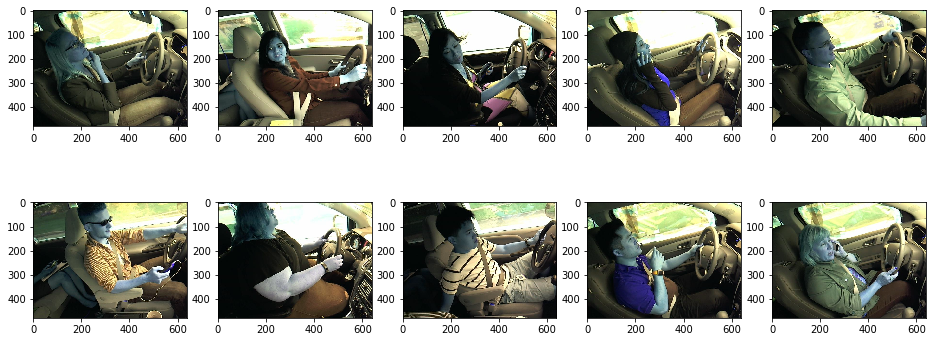

In [18]:
import random
sample_train_path = pjoin(data_path, train_name)
example_images = []

for ctg in os.listdir(sample_train_path):
    ctg_path = pjoin(sample_train_path, ctg)
    image_path = pjoin(ctg_path, random.choice(os.listdir(ctg_path)))
    image = cv2.imread(image_path)
    example_images.append(image)

plot_images(example_images, columns=5)

## Try different models

### Data flow

In [10]:
work_path = data_path
train_flow = wrap_data_gen(pjoin(work_path, train_name)).flow_from_directory(shuffle=True)
test_flow = wrap_data_gen(pjoin(work_path, test_name)).flow_from_directory()
valid_flow = wrap_data_gen(pjoin(work_path, valid_name)).flow_from_directory()

Found 15692 images belonging to 10 classes.
Found 2247 images belonging to 10 classes.
Found 4485 images belonging to 10 classes.


### Basic FC models

In [5]:
lr_decay = callbacks.ReduceLROnPlateau(factor=0.2, patience=2, verbose=1, epsilon=0.001,)

In [6]:
def build_fc_model():
    # built model
    inputs = Input(shape=train_flow.image_shape)
    x = Flatten()(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(600, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization(axis=1)(x)
    # a layer instance is callable on a tensor, and returns a tensor
    predictions = Dense(train_flow.num_classes, activation='softmax')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    return Model(inputs=inputs, outputs=predictions)

fc_model = build_fc_model()

Epoch 1/10
49/49 [==============================] - 8s 169ms/step - loss: 1.5037 - acc: 0.5169 - val_loss: 0.7681 - val_acc: 0.7522


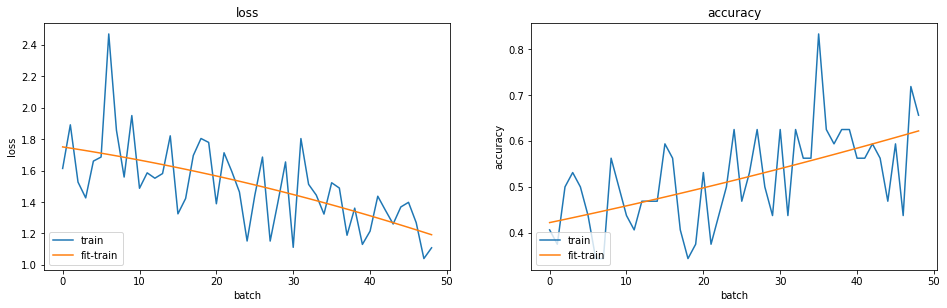

Epoch 2/10
49/49 [==============================] - 10s 199ms/step - loss: 0.7962 - acc: 0.7455 - val_loss: 0.5095 - val_acc: 0.8409


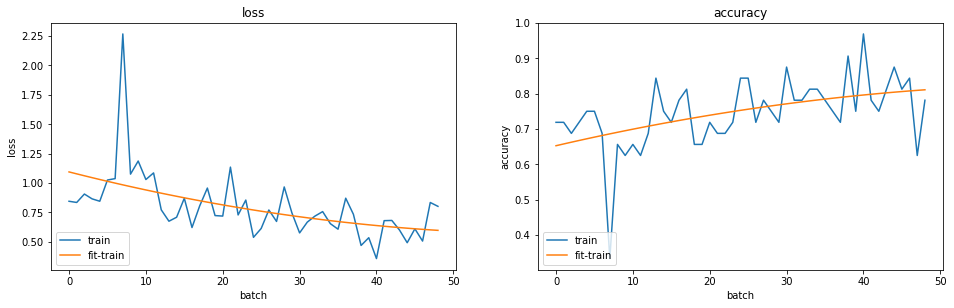

Epoch 3/10
49/49 [==============================] - 9s 191ms/step - loss: 0.4519 - acc: 0.8622 - val_loss: 0.3652 - val_acc: 0.9074


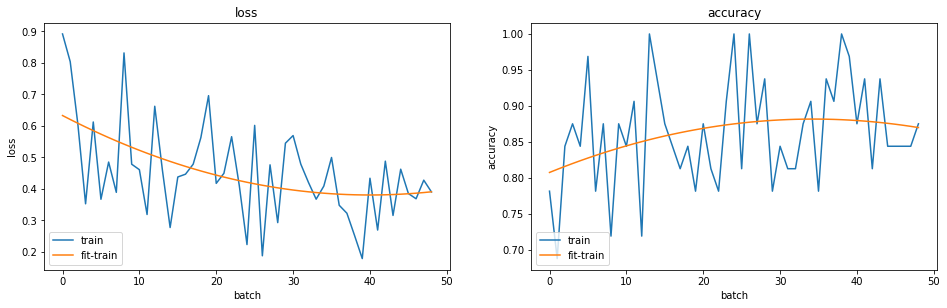

Epoch 4/10
49/49 [==============================] - 9s 188ms/step - loss: 0.3136 - acc: 0.9027 - val_loss: 0.2904 - val_acc: 0.9121


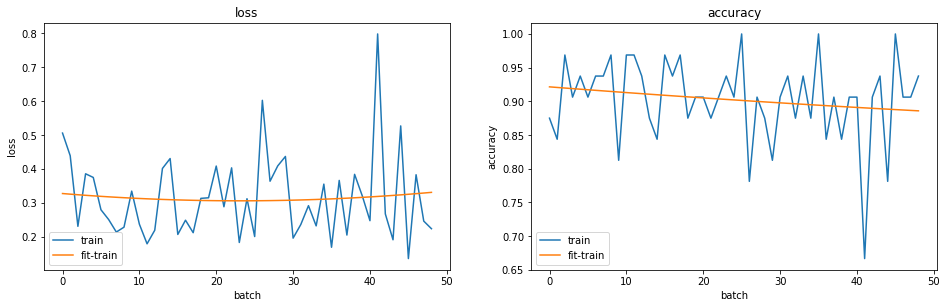

Epoch 5/10
49/49 [==============================] - 9s 180ms/step - loss: 0.2497 - acc: 0.9270 - val_loss: 0.2920 - val_acc: 0.9145


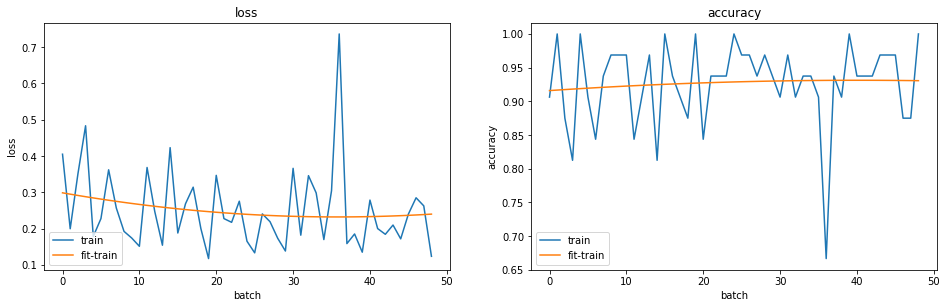

Epoch 6/10
49/49 [==============================] - 9s 184ms/step - loss: 0.1679 - acc: 0.9598 - val_loss: 0.2444 - val_acc: 0.9287


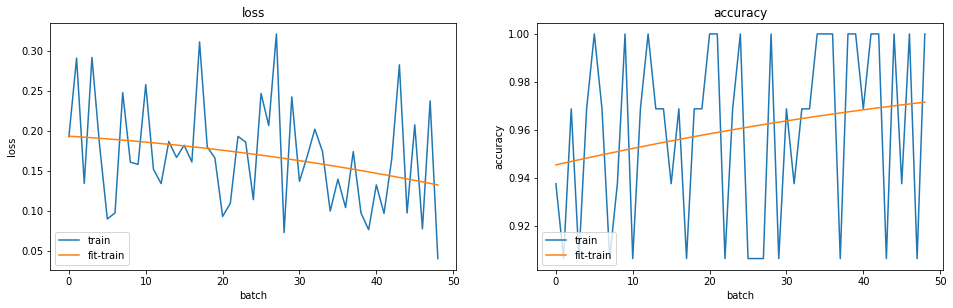

Epoch 7/10
49/49 [==============================] - 9s 179ms/step - loss: 0.1340 - acc: 0.9673 - val_loss: 0.2214 - val_acc: 0.9382


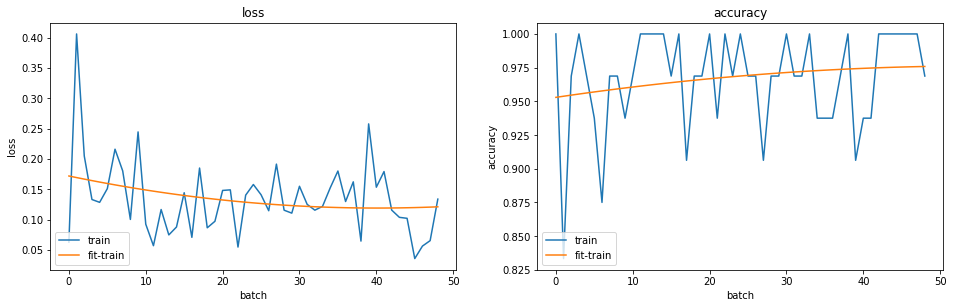

Epoch 8/10
49/49 [==============================] - 9s 174ms/step - loss: 0.1610 - acc: 0.9557 - val_loss: 0.1963 - val_acc: 0.9335


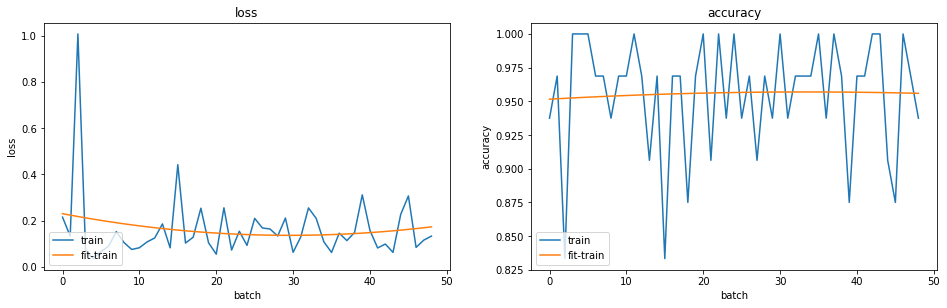

Epoch 9/10
49/49 [==============================] - 8s 170ms/step - loss: 0.0996 - acc: 0.9758 - val_loss: 0.1614 - val_acc: 0.9549


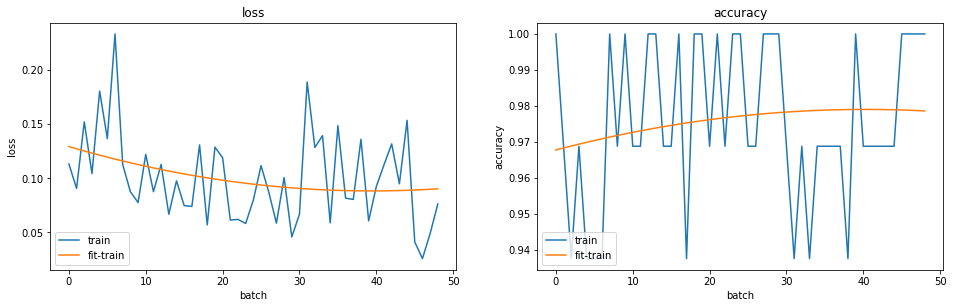

Epoch 10/10
49/49 [==============================] - 8s 165ms/step - loss: 0.0686 - acc: 0.9853 - val_loss: 0.1403 - val_acc: 0.9572


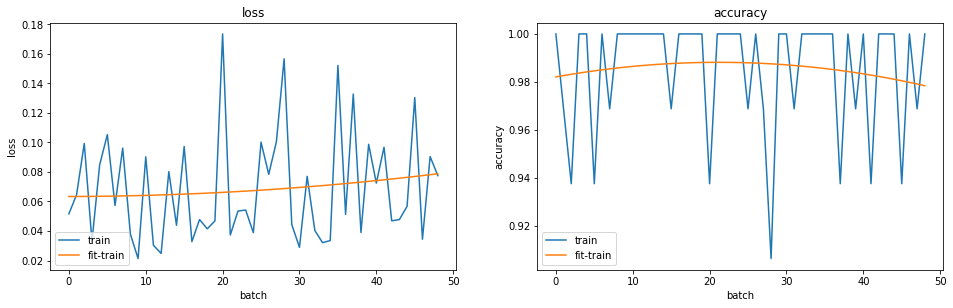

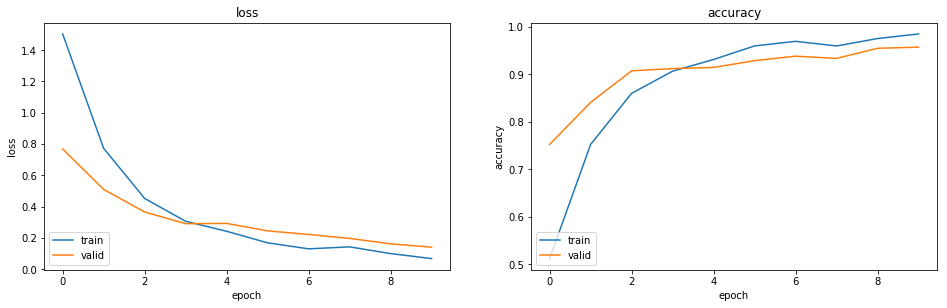

In [8]:
fc_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
fit_generator(fc_model, train_flow, valid_flow, epochs=10, callbacks=[lr_decay])

In [11]:
fc_model.evaluate_generator(test_flow)

[0.187086444535439, 0.9550511793502447]

Here, I tested two fc model on sample data: 
    - linear model, 25 epochs, valid_loss 10.686
    - one hidden layer, 10 epoch, valid_loss 0.14, test_loss 0.169, 0.187 real_test_loss

## Submit result 

### data flow

In [16]:
submit_model = fc_model
submit_flow = wrap_data_gen(pjoin(data_path, 'test')).flow_from_directory()

Found 79726 images belonging to 1 classes.


In [17]:
predictions = submit_model.predict_generator(submit_flow)

In [27]:
filenames = np.array([[name.split('/')[1]] for name in submit_flow.filenames])

In [41]:
submit = np.hstack([filenames, predictions])

In [44]:
submit_name = 'submit_fc_one_hidden.csv'
np.savetxt(submit_name, submit, fmt='%s' + ',%s'*10, header='img,{}'.format(','.join(train_flow.class_indices.keys())), comments='')

In [46]:
cli.submit_result(submit_name)